# Trial for PPE Detection YOLOv8


In [16]:
import requests
import zipfile
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

## Connected to GPU

In [1]:
!nvidia-smi

Sat Apr 27 03:38:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
# Cloning ultralytics repository
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 24592, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 24592 (delta 10), reused 35 (delta 10), pack-reused 24554
Receiving objects: 100% (24592/24592), 14.49 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (17341/17341), done.


## Install Ultralytics YOLO libraries

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.1/752.1 kB 10.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [4]:
%cd /content

/content


In [6]:
import gdown

url = 'https://drive.google.com/file/d/1m8hrNkwYZQkolveI_oPWBe_oWJZv2Iuh/view?usp=sharing'
file_id = url.split("/")[-2]
prefix = "https://drive.google.com/uc?/export=download&id="

gdown.download(prefix + file_id)
print("Data downloaded!")

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1m8hrNkwYZQkolveI_oPWBe_oWJZv2Iuh
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1m8hrNkwYZQkolveI_oPWBe_oWJZv2Iuh&confirm=t&uuid=647beeed-5e37-4436-9ffd-b5d056d22e24
To: /content/ppe-detection.zip
100%|██████████| 82.2M/82.2M [00:01<00:00, 76.4MB/s]

Data downloaded!


In [8]:
!unzip ppe-detection.zip
!rm -rf ppe-detection.zip

Archive:  ppe-detection.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/-4405-_png_jpg.rf.937688313347dbcd3b24201dd7882906.jpg  
 extracting: test/images/000005_jpg.rf.c613c066b79795d219855aca269760e6.jpg  
 extracting: test/images/002551_jpg.rf.b09484b130c1587abfa8365c3d774bf1.jpg  
 extracting: test/images/003357_jpg.rf.9fb1f2cebc239b4276a81ce2cbf9e911.jpg  
 extracting: test/images/004063_jpg.rf.6ecc587c20a87ec176841aea39b8f5db.jpg  
 extracting: test/images/004763_jpg.rf.c8f1bd1cb7cf6037f7c90a6c213d6364.jpg  
 extracting: test/images/006463_jpg.rf.f134bfc3f96f0e501a027414ffffcc82.jpg  
 extracting: test/images/006672_jpg.rf.657b0a9ecd720d07ca5dd75338a058d5.jpg  
 extracting: test/images/0_jpg.rf.209c19e4338c1f03ab706bb5a60a7ebc.jpg  
 extracting: test/images/2008_008320_jpg.rf.a1f52d3537abe3e294e37dd0476e3213.jpg  
 extracting: test/images/2008

In [9]:
# This is the YAML file we 're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 25
names: ['Excavator', 'Gloves', 'Hardhat', 'Ladder', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'SUV', 'Safety Cone', 'Safety Vest', 'bus', 'dump truck', 'fire hydrant', 'machinery', 'mini-van', 'sedan', 'semi', 'trailer', 'truck and trailer', 'truck', 'van', 'vehicle', 'wheel loader']

roboflow:
  workspace: roboflow-universe-projects
  project: construction-site-safety
  version: 30
  license: CC BY 4.0
  url: https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety/dataset/30

In [14]:
!yolo task=detect mode=train model=yolov8l.pt data="../content/data.yaml" epochs=50 imgsz=640

100% 83.7M/83.7M [00:00<00:00, 300MB/s]
Ultralytics YOLOv8.2.3 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=../content/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

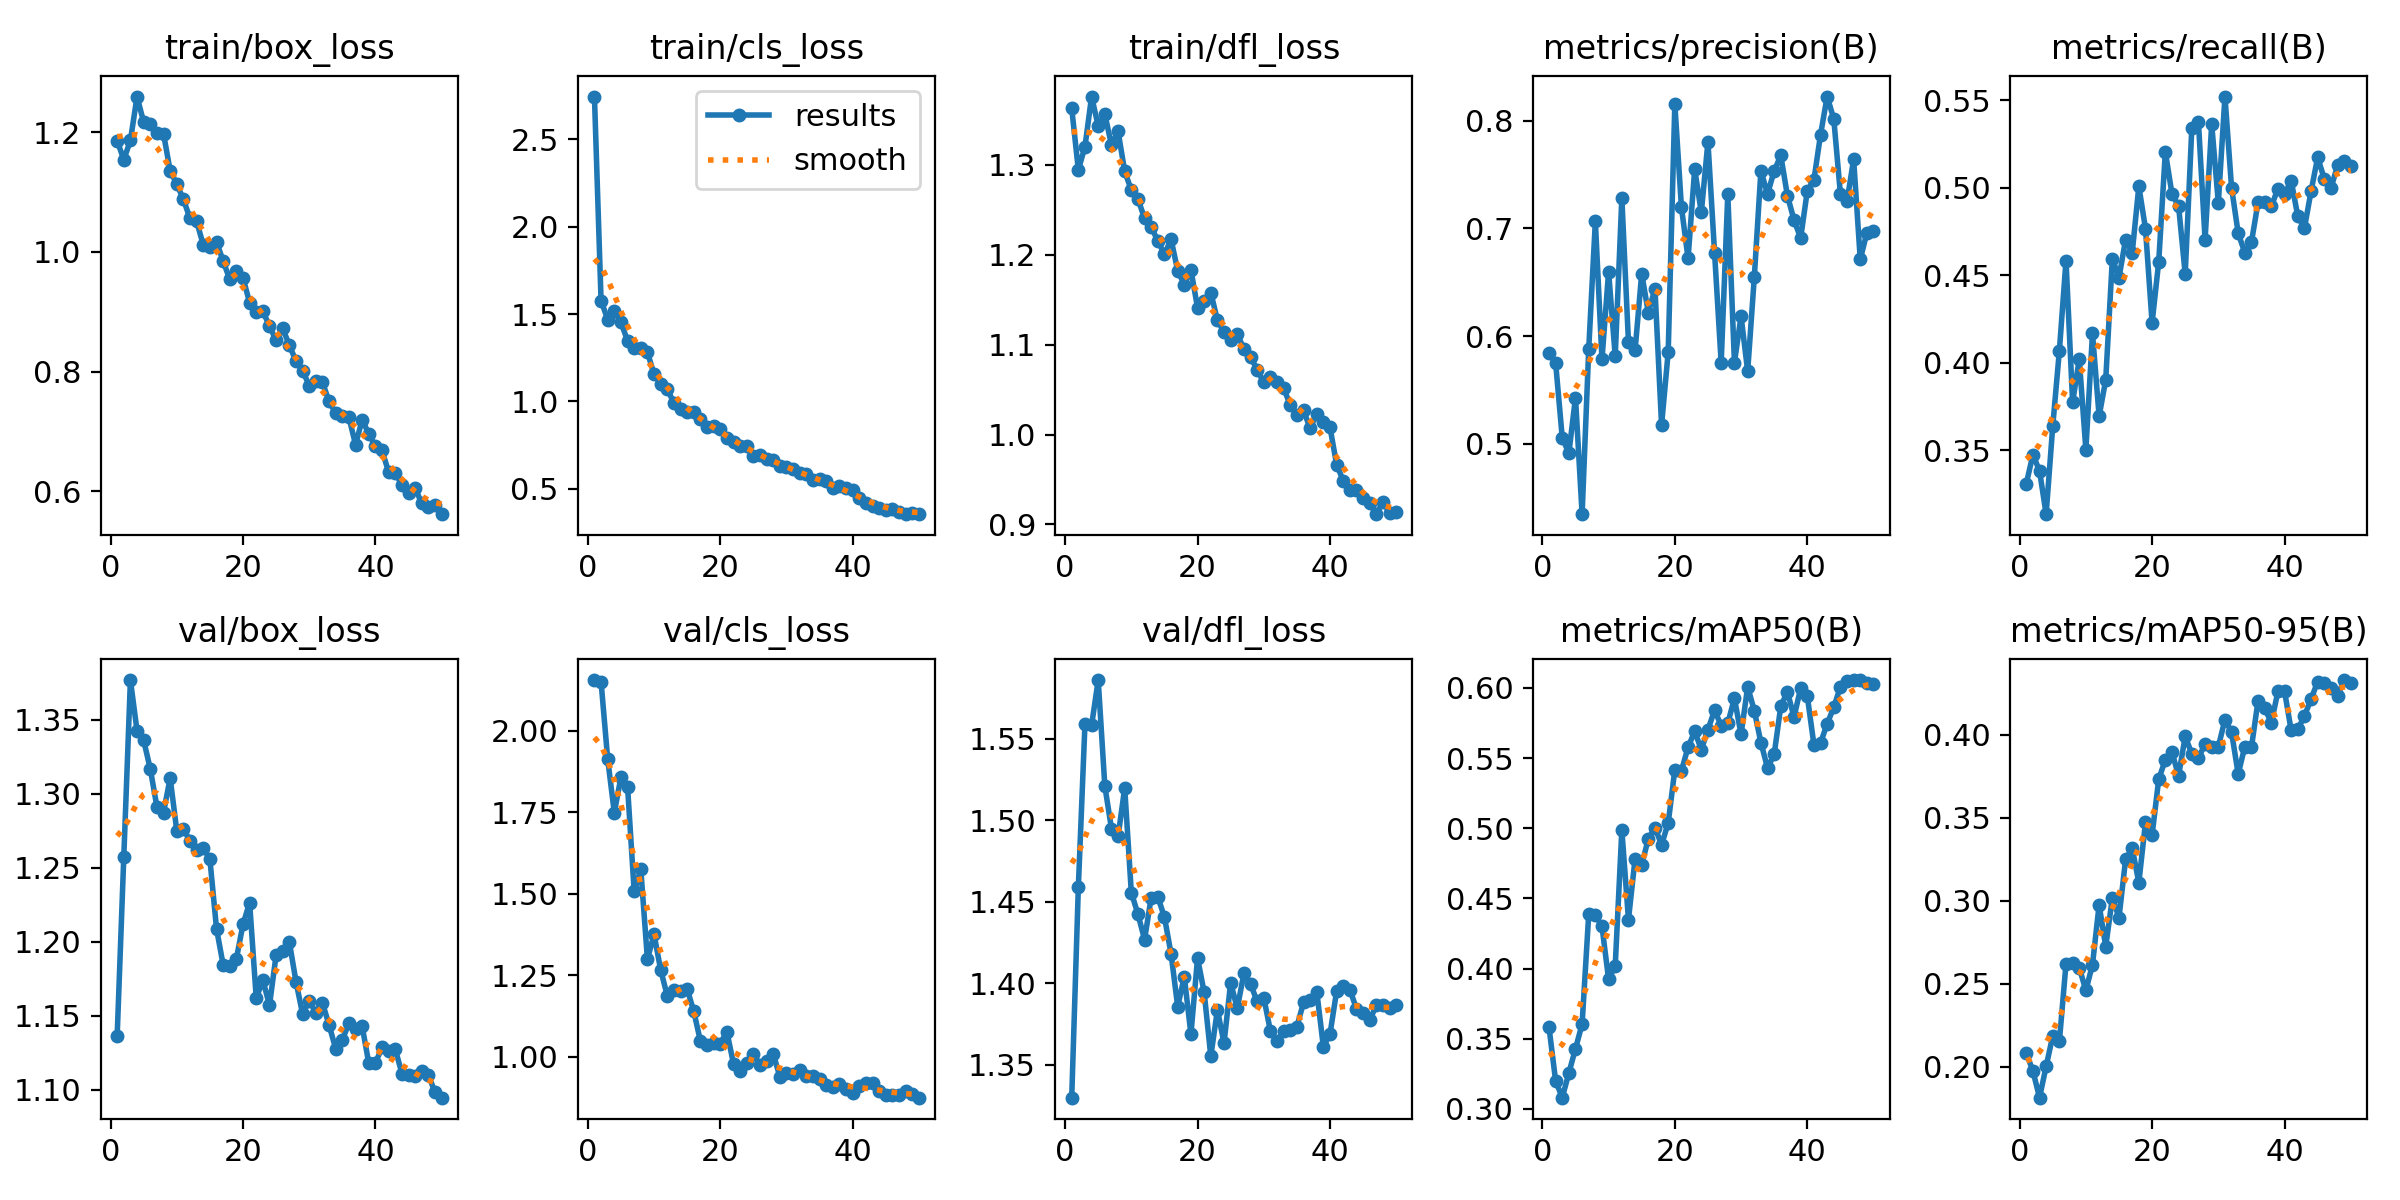

In [22]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from IPython.display import Image, clear_output # to display images
Image(filename='/content/runs/detect/train/results.png', width=1000)  # view results.png

In [15]:
!yolo predict \
model='/content/runs/detect/train/weights/best.pt' \
source='/content/valid/images' \
name='yolov8l_predict' \
exist_ok=True \
save=True

Ultralytics YOLOv8.2.3 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43625883 parameters, 0 gradients, 164.9 GFLOPs

image 1/114 /content/valid/images/-1079-_png_jpg.rf.77459a818bed5a44927d46bdb976c661.jpg: 640x640 1 Excavator, 2 Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 5 Persons, 1 Safety Vest, 62.9ms
image 2/114 /content/valid/images/-1429-_png_jpg.rf.d88afaebfda9ebdd21b532caeceb70fd.jpg: 640x640 2 Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 2 Persons, 1 Safety Vest, 63.0ms
image 3/114 /content/valid/images/-1969-_png_jpg.rf.c383b0a9a12f96b66d8089f4b4cb8b5c.jpg: 640x640 1 Hardhat, 1 NO-Mask, 62.9ms
image 4/114 /content/valid/images/-1989-_png_jpg.rf.3f49422a352c92297c67d4c2fd51432d.jpg: 640x640 2 Glovess, 5 Hardhats, 1 NO-Hardhat, 4 NO-Masks, 5 NO-Safety Vests, 8 Persons, 54.0ms
image 5/114 /content/valid/images/-211-_png_jpg.rf.63b7213fc11cd2d7db6d8fff0e490d2c.jpg: 640x640 2 Persons, 2 Safety Vests, 36.2ms
image 6/114 /content/valid/image

In [17]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir):
    """
    Function accepts a list of images and plots
    them in either a 1x1 grid or 2x2 grid.
    """
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    if len(image_names) < 4:
        plt.figure(figsize=(10, 7))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(1, 1, i+1)
            plt.imshow(image)
            plt.axis('off')
            break
    if len(image_names) >= 4:
        plt.figure(figsize=(15, 12))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(2, 2, i+1)
            plt.imshow(image)
            plt.axis('off')
            if i == 3:
                break
    plt.tight_layout()
    plt.show()

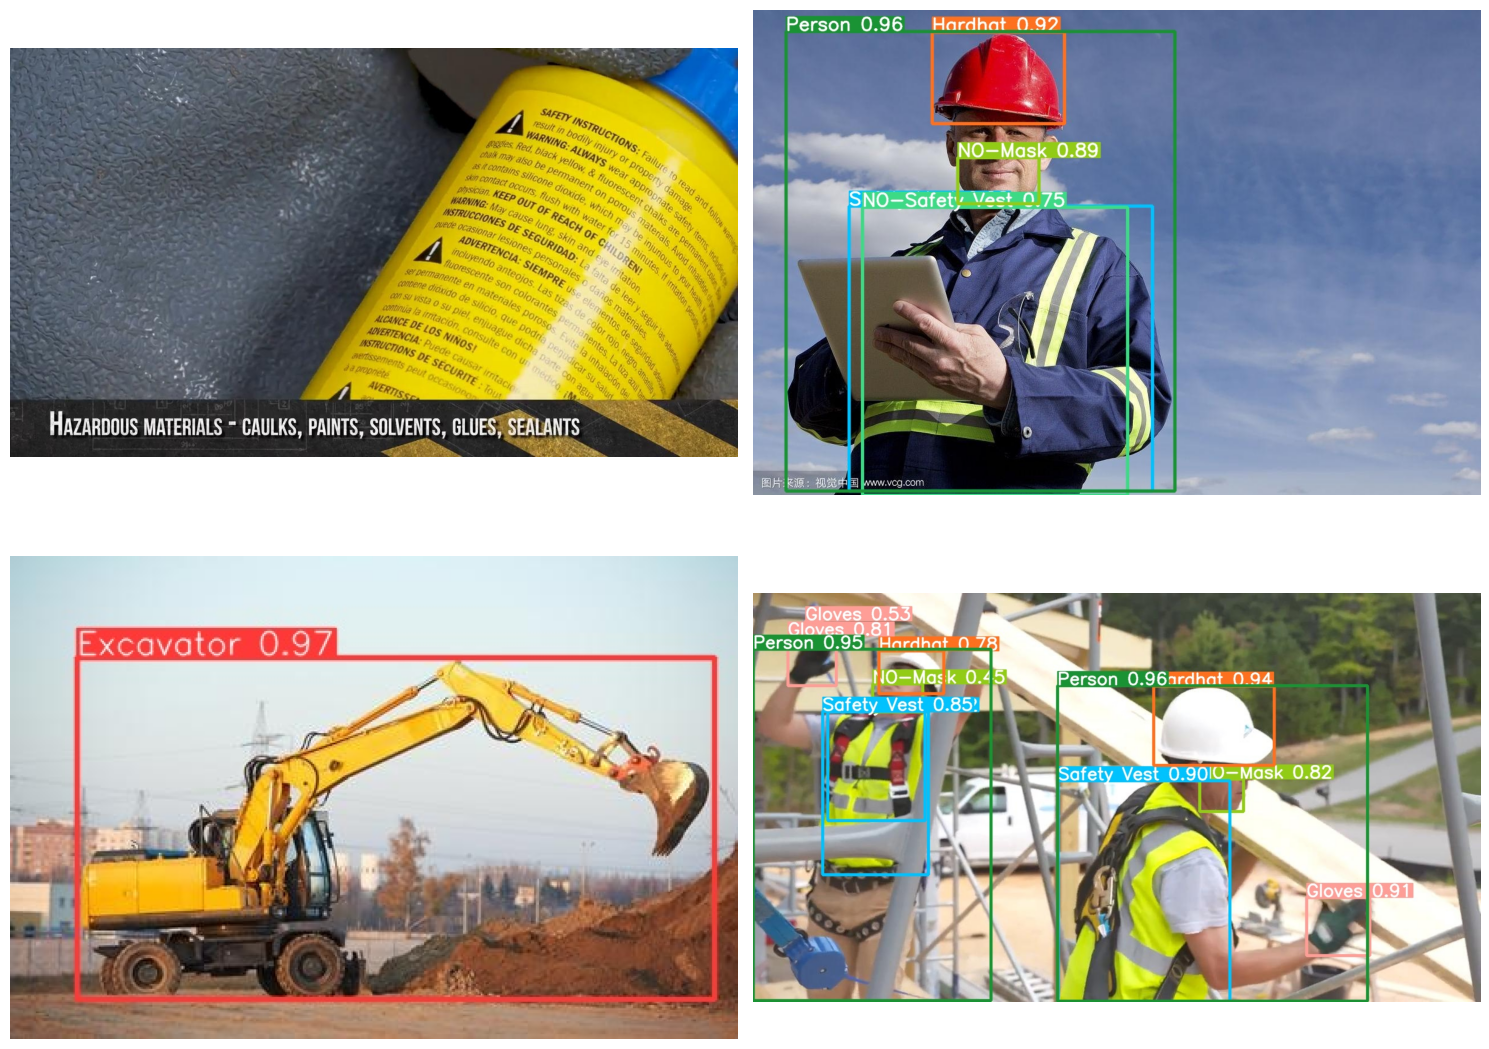

In [19]:
visualize('/content/runs/detect/yolov8l_predict')

### Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere.

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
